# Querying the Human Lung Cell Atlas

Here we demonstrate how to query the Human Lung Cell Atlas using scANVI, scArches, and scvi-hub.

- Sikkema, Lisa, et al. "An integrated cell atlas of the human lung in health and disease." [bioRxiv](https://www.biorxiv.org/content/10.1101/2022.03.10.483747v1) (2022).

If you use this tutorial in your research we recommend citing the HLCA as well as scANVI, scArches, and scvi-tools, which can be found on the [references page](https://docs.scvi-tools.org/en/stable/references.html) at Gayoso22, Lotfollahi21, Xu21 respectively.

This tutorial is adapted from a [similar one](https://github.com/LungCellAtlas/mapping_data_to_the_HLCA/blob/main/notebooks/LCA_scArches_mapping_new_data_to_hlca.ipynb) presented by the HLCA authors.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import anndata
import numba
import numpy as np
import pandas as pd
import pooch
import pynndescent
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.hub import HubModel
from scvi.model.utils import mde

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'
  """


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Download the reference files

First we download the pre-trained scANVI model from the HuggingFace [repo](https://huggingface.co/scvi-tools/human-lung-cell-atlas).

In [5]:
hubmodel = HubModel.pull_from_huggingface_hub(
    "scvi-tools/human-lung-cell-atlas", cache_dir=save_dir.name
)
adata = hubmodel.adata
model = hubmodel.model

/tmp/ipykernel_153/600709524.py:1: UserWarning: No revision was passed, so the default (latest) revision will be used.
  hubmodel = HubModel.pull_from_huggingface_hub(


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

_scvi_required_metadata.json:   0%|          | 0.00/247 [00:00<?, ?B/s]

model.pt:   0%|          | 0.00/5.83M [00:00<?, ?B/s]

adata.h5ad:   0%|          | 0.00/905M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

INFO     Reading adata...                                                                                          


INFO     Loading model...                                                                                          


INFO     File                                                                                                      
         /tmp/tmppp7v4nri/models--scvi-tools--human-lung-cell-atlas/snapshots/7af8f610b2c46b715e62cf46bc14163d8a3e6
         79e/model.pt already downloaded                                                                           


/usr/local/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

/usr/local/lib/python3.12/site-packages/scvi/data/fields/_dataframe_field.py:224: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/usr/local/lib/python3.12/site-packages/scvi/data/fields/_scanvi.py:55: UserWarning: Category 18 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [6]:
adata

AnnData object with n_obs × n_vars = 584944 × 2000
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'o

In [7]:
model

ScanVI Model with the following params: 
unlabeled_category: unlabeled, n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Trained
Model's adata is minified?: True

In [8]:
model.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.6.

Setup via `SCANVI.setup_anndata` with arguments:

{
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled',
│   'layer': None,
│   'batch_key': 'dataset',
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   14   │
│         n_cells          │ 584944 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   29   │
│       n_latent_qzm       │   30   │
│       n_latent_qzv       │   30   │
│          n_vars          │  2000  │
└──────────────────────────┴────────┘

                        Data Registry                         
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Registry Key    ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         X         │                adata.X                 │
│       batch       │        adata.obs['_scvi_batch']        │
│      labels       │       adata.obs['_scvi_labels']        │
│    latent_qzm     │    adata.obsm['_scanvi_latent_qzm']    │
│    latent_qzv     │    adata.obsm['_scanvi_latent_qzv']    │
│    minify_type    │  adata.uns['_scvi_adata_minify_type']  │
│ observed_lib_size │ adata.obs['_scanvi_observed_lib_size'] │
└───────────────────┴────────────────────────────────────────┘

                           batch State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │   Banovich_Kropski_2020   │          0          │
│                      │     Barbry_Leroy_2020     │          1          │
│                      │ Jain_Misharin_2021_10Xv1  │          2          │
│                      │ Jain_Misharin_2021_10Xv2  │          3          │
│                      │       Krasnow_2020        │          4          │
│                      │ Lafyatis_Rojas_2019_10Xv1 │          5          │
│                      │ Lafyatis_Rojas_2019_10Xv2 │          6          │
│                      │        Meyer_2019         │          7          │
│                      │       Misharin_2021       │          8          │
│                      │  Misharin_Budinger_2018   │          9          │
│                      │        Nawijn_2021        │         10          │
│                      │    Seibold_2020_10Xv2     │         11          │
│                      │    Seibold_2020_10Xv3     │         12          │
│                      │   Teichmann_Meyer_2019    │         13          │
└──────────────────────┴───────────────────────────┴─────────────────────┘

                            labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['scanvi_label'] │           AT1           │          0          │
│                           │           AT2           │          1          │
│                           │       Arterial EC       │          2          │
│                           │     B cell lineage      │          3          │
│                           │          Basal          │          4          │
│                           │   Bronchial Vessel 1    │          5          │
│                           │   Bronchial Vessel 2    │          6          │
│                           │        Capillary        │          7          │
│                           │        Ciliated         │          8          │
│                           │     Dendritic cells     │          9          │
│                           │   Fibroblast lineage    │         10          │
│                           │ KRT5- KRT17+ epithelial │         11          │
│                           │      Lymphatic EC       │         12          │
│                           │       Macrophages       │         13          │
│                           │       Mast cells        │         14          │
│                           │     Megakaryocytes      │         15          │
│                           │       Mesothelium       │         16          │
│                           │        Monocytes        │         17          │
│                           │      Neutrophilic       │         18          │
│                           │      Non-T/B cells      │         19          │
│                           │   Proliferating cells   │         20          │
│                           │          Rare           │         21          │
│                           │        Secretory        │         22          │
│                           │      Smooth Muscle      │         23          │
│                           │        Squamous         │         24          │
│                           │  Submucosal Secretory   │         25          │
│                           │     T cell lineage      │         26          │
│                           │         Venous          │         27          │
│                           │        unlabeled        │         28          │
└───────────────────────────┴─────────────────────────┴─────────────────────┘

## Learn a neighbors index on reference latent space

Here we create the neighbors index using `PyNNDescent`. We will use this later to classify query cells. `PyNNDescent` is an extremely fast approximate neighbors technique.

In the case of the `HubModel` instance above, we see that the data is in minified mode, meaning the count data is not actually in the object, and we only store a minified representation of the data. We see that we can access the mean of the embedding (`latent_qzm`) above.

In [9]:
X_train = adata.obsm["_scanvi_latent_qzm"]
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

## Download query data

In this tutorial we use the fresh, single-cell sample from the following publication:

- Delorey, Toni M., et al. "COVID-19 tissue atlases reveal SARS-CoV-2 pathology and cellular targets." Nature 595.7865 (2021): 107-113.

In principle at this stage you may load your own data. There are few important notes though:

- Using the HLCA requires using Gene IDs for the query data
- The query data should include batches in `query_data.obs["dataset"]`
- It's necessary to run `query_data.obs["scanvi_label"] = "unlabeled"` so that scvi-tools can properly register the query data.

In [10]:
def download_data(save_path: str):
    """Download and cache the query data."""
    data_path = pooch.retrieve(
        url="https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM5230nnn/GSM5230027/suppl/GSM5230027_04-P103142-S149-R01_raw_feature_bc_matrix.h5.gz",
        known_hash="3b7f8318059d655ea774752b6d8b13381323f5018e9f3868ffc53674f94f537f",
        fname="query_data.h5.gz",
        path=save_path,
        processor=pooch.Decompress(),
        progressbar=True,
    )
    metadata_path = pooch.retrieve(
        url="https://ftp.ncbi.nlm.nih.gov/geo/series/GSE171nnn/GSE171668/suppl/GSE171668_lung_metadata.csv.gz",
        known_hash="290b0ac86e85183e65eefb68670ad27fc5156866144d9ac6f2eb27f34e31e79e",
        fname="query_metadata.csv.gz",
        path=save_path,
        processor=pooch.Decompress(),
        progressbar=True,
    )
    return data_path, metadata_path

In [11]:
query_data_path, query_metadata_path = download_data(save_dir.name)

query_adata = sc.read_10x_h5(query_data_path)
query_metadata = pd.read_csv(query_metadata_path, index_col=0)

  0%|                                              | 0.00/27.4M [00:00<?, ?B/s]

  0%|                                   | 1.02k/27.4M [00:00<1:00:39, 7.52kB/s]

  0%|                                      | 33.8k/27.4M [00:00<03:10, 143kB/s]

  0%|▏                                     | 99.3k/27.4M [00:00<01:32, 295kB/s]

  1%|▎                                      | 214k/27.4M [00:00<00:53, 506kB/s]

  2%|▌                                      | 427k/27.4M [00:00<00:30, 880kB/s]

  3%|█▏                                    | 886k/27.4M [00:00<00:15, 1.71MB/s]

  6%|██▎                                  | 1.69M/27.4M [00:01<00:14, 1.83MB/s]

 17%|██████                               | 4.52M/27.4M [00:01<00:03, 5.94MB/s]

 20%|███████▎                             | 5.37M/27.4M [00:01<00:03, 5.99MB/s]

 23%|████████▍                            | 6.23M/27.4M [00:01<00:03, 6.04MB/s]

 26%|█████████▌                           | 7.08M/27.4M [00:01<00:03, 6.07MB/s]

 29%|██████████▋                          | 7.93M/27.4M [00:01<00:03, 6.09MB/s]

 32%|███████████▊                         | 8.78M/27.4M [00:02<00:03, 6.11MB/s]

 35%|█████████████                        | 9.65M/27.4M [00:02<00:02, 6.16MB/s]

 38%|██████████████▏                      | 10.5M/27.4M [00:02<00:02, 6.17MB/s]

 42%|███████████████▎                     | 11.4M/27.4M [00:02<00:02, 6.19MB/s]

 45%|████████████████▌                    | 12.2M/27.4M [00:02<00:02, 6.18MB/s]

 48%|█████████████████▋                   | 13.1M/27.4M [00:02<00:02, 6.21MB/s]

 51%|██████████████████▉                  | 14.0M/27.4M [00:02<00:02, 6.24MB/s]

 54%|████████████████████                 | 14.8M/27.4M [00:03<00:02, 6.25MB/s]

 57%|█████████████████████▎               | 15.7M/27.4M [00:03<00:01, 6.33MB/s]

 61%|██████████████████████▍              | 16.6M/27.4M [00:03<00:01, 6.35MB/s]

 64%|███████████████████████▋             | 17.5M/27.4M [00:03<00:01, 6.43MB/s]

 67%|████████████████████████▉            | 18.5M/27.4M [00:03<00:01, 6.53MB/s]

 71%|██████████████████████████▏          | 19.4M/27.4M [00:03<00:01, 6.59MB/s]

 74%|███████████████████████████▌         | 20.4M/27.4M [00:03<00:01, 6.67MB/s]

 78%|████████████████████████████▊        | 21.3M/27.4M [00:04<00:00, 6.80MB/s]

 82%|██████████████████████████████▏      | 22.3M/27.4M [00:04<00:00, 6.90MB/s]

 85%|███████████████████████████████▌     | 23.3M/27.4M [00:04<00:00, 7.00MB/s]

 89%|████████████████████████████████▉    | 24.3M/27.4M [00:04<00:00, 7.09MB/s]

 93%|██████████████████████████████████▎  | 25.4M/27.4M [00:04<00:00, 7.24MB/s]

 97%|███████████████████████████████████▋ | 26.4M/27.4M [00:04<00:00, 7.34MB/s]

  0%|                                              | 0.00/27.4M [00:00<?, ?B/s]

100%|█████████████████████████████████████| 27.4M/27.4M [00:00<00:00, 47.0GB/s]


Decompressing '/tmp/tmppp7v4nri/query_data.h5.gz' to '/tmp/tmppp7v4nri/query_data.h5.gz.decomp' using method 'auto'.


  0%|                                              | 0.00/1.95M [00:00<?, ?B/s]

  0%|                                     | 1.02k/1.95M [00:00<04:18, 7.54kB/s]

  2%|▋                                     | 33.8k/1.95M [00:00<00:13, 144kB/s]

  5%|█▉                                    | 99.3k/1.95M [00:00<00:06, 296kB/s]

 11%|████▎                                  | 214k/1.95M [00:00<00:03, 509kB/s]

 23%|████████▉                              | 443k/1.95M [00:00<00:01, 926kB/s]

 46%|█████████████████▌                    | 902k/1.95M [00:00<00:00, 1.74MB/s]

 84%|███████████████████████████████▏     | 1.64M/1.95M [00:00<00:00, 2.88MB/s]

 99%|████████████████████████████████████▌| 1.92M/1.95M [00:01<00:00, 2.65MB/s]

  0%|                                              | 0.00/1.95M [00:00<?, ?B/s]

100%|█████████████████████████████████████| 1.95M/1.95M [00:00<00:00, 6.70GB/s]


Decompressing '/tmp/tmppp7v4nri/query_metadata.csv.gz' to '/tmp/tmppp7v4nri/query_metadata.csv.gz.decomp' using method 'auto'.


/usr/local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
# clean up .var.index (gene names)
query_adata.var["gene_names"] = query_adata.var.index
query_adata.var.index = [idx.split("___")[-1] for idx in query_adata.var.gene_ids]
# clean up cell barcodes:
query_adata.obs.index = query_adata.obs.index.str.rstrip("-1")
# read in metadata (to select only cells of interest and remove empty drops)
# subset to cells from our sample
query_metadata = query_metadata.loc[query_metadata.donor == "D12_4", :].copy()
# clean up barcodes:
query_metadata.index = [idx.split("-")[-1] for idx in query_metadata.index]
# subset adata to cells in metadata:
query_adata = query_adata[query_metadata.index, :].copy()
# add dataset information:
query_adata.obs["dataset"] = "test_dataset_delorey_regev"

## Loading the query model from the reference files

Here we run `prepare_query_anndata`, which reorders the genes and pads any missing genes with 0s. This should generally be run before reference mapping with scArches to ensure data correctness.

```{important}
Below we use the path to the model we downloaded from HuggingFace. While in most cases the model instance can be used instead of the path, here the reference model's adata is in minified mode.
```

In [13]:
scvi.model.SCANVI.prepare_query_anndata(query_adata, model)

INFO     Found 99.65% reference vars in query data.                                                                


From above, we see that the model is expecting a labels key with the name `"scanvi_label"`.

In [14]:
query_adata.obs["scanvi_label"] = "unlabeled"

In [15]:
query_model = scvi.model.SCANVI.load_query_data(query_adata, model)

Here we use scArches/scANVI-specific query training arguments.

In [16]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [17]:
query_model.train(max_epochs=surgery_epochs, **train_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric elbo_train did not improve in the last 10 records. Best score: 514.790. Signaling Trainer to stop.


In [18]:
query_model_path = os.path.join(save_dir.name, "query_model")
query_model.save(query_model_path, overwrite=True)

In [19]:
query_emb = anndata.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_adata.obs_names

Now let's store the predictions in the query embedding object. We reuse the PyNNDescent index from before, converting distances to affinities, and weighting the predictions using these affinities.

This follows the same approach used in the HLCA.

In [20]:
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)


@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty


# for each annotation level, get prediction and uncertainty
label_keys = [f"ann_level_{i}" for i in range(1, 6)] + ["ann_finest_level"]
for l in label_keys:
    ref_cats = adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u

Now let's filter our predictions on the uncertainty threshold, which is discussed in the HLCA manuscript.

In [21]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"

ann_level_1: 0.0033594624860022394 unknown
ann_level_2: 0.005039193729003359 unknown
ann_level_3: 0.06886898096304592 unknown
ann_level_4: 0.3572228443449048 unknown
ann_level_5: 0.008958566629339306 unknown
ann_finest_level: 0.37793952967525196 unknown


/tmp/ipykernel_153/642663619.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"
/tmp/ipykernel_153/642663619.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [22]:
query_emb.obs["dataset"] = "test_dataset_delorey_regev"

## Combine embeddings

In [23]:
ref_emb = anndata.AnnData(X_train, obs=adata.obs)
ref_emb

AnnData object with n_obs × n_vars = 584944 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'ori

In [24]:
query_emb

AnnData object with n_obs × n_vars = 1786 × 30
    obs: 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty', 'dataset'

In [25]:
combined_emb = ref_emb.concatenate(query_emb)

/tmp/ipykernel_153/852954867.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  combined_emb = ref_emb.concatenate(query_emb)


## Visualize embeddings and predictions

To visualize here we use [minimum distortion embeddings](https://pymde.org/), which for now can be thought of as an alternative of UMAP that is GPU-accelerated (= really fast on Colab). While we use `init="random"` here, we recommend removing this argument in practice and only leave it here to make the notebook run faster.

In [26]:
MDE_KEY = "X_mde"
combined_emb.obsm[MDE_KEY] = mde(combined_emb.X, init="random")

/usr/local/lib/python3.12/site-packages/pymde/functions/losses.py:1: SyntaxWarning: invalid escape sequence '\d'
  """Losses: distortion functions derived from original deviations.
/usr/local/lib/python3.12/site-packages/pymde/functions/losses.py:102: SyntaxWarning: invalid escape sequence '\e'
  """
/usr/local/lib/python3.12/site-packages/pymde/functions/penalties.py:311: SyntaxWarning: invalid escape sequence '\l'
  """:math:`p(d) = \log(1 + d^{\\text{exponent}})`"""
/usr/local/lib/python3.12/site-packages/pymde/functions/penalties.py:325: SyntaxWarning: invalid escape sequence '\l'
  """:math:`p(d) = \log(1 - \\exp(-d^\\text{exponent}))`"""


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/usr/local/lib/python3.12/site-packages/pymde/quadratic.py:126: SyntaxWarning: invalid escape sequence '\q'
  """Compute a spectral embedding


In [27]:
combined_emb

AnnData object with n_obs × n_vars = 586730 × 30
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'ori

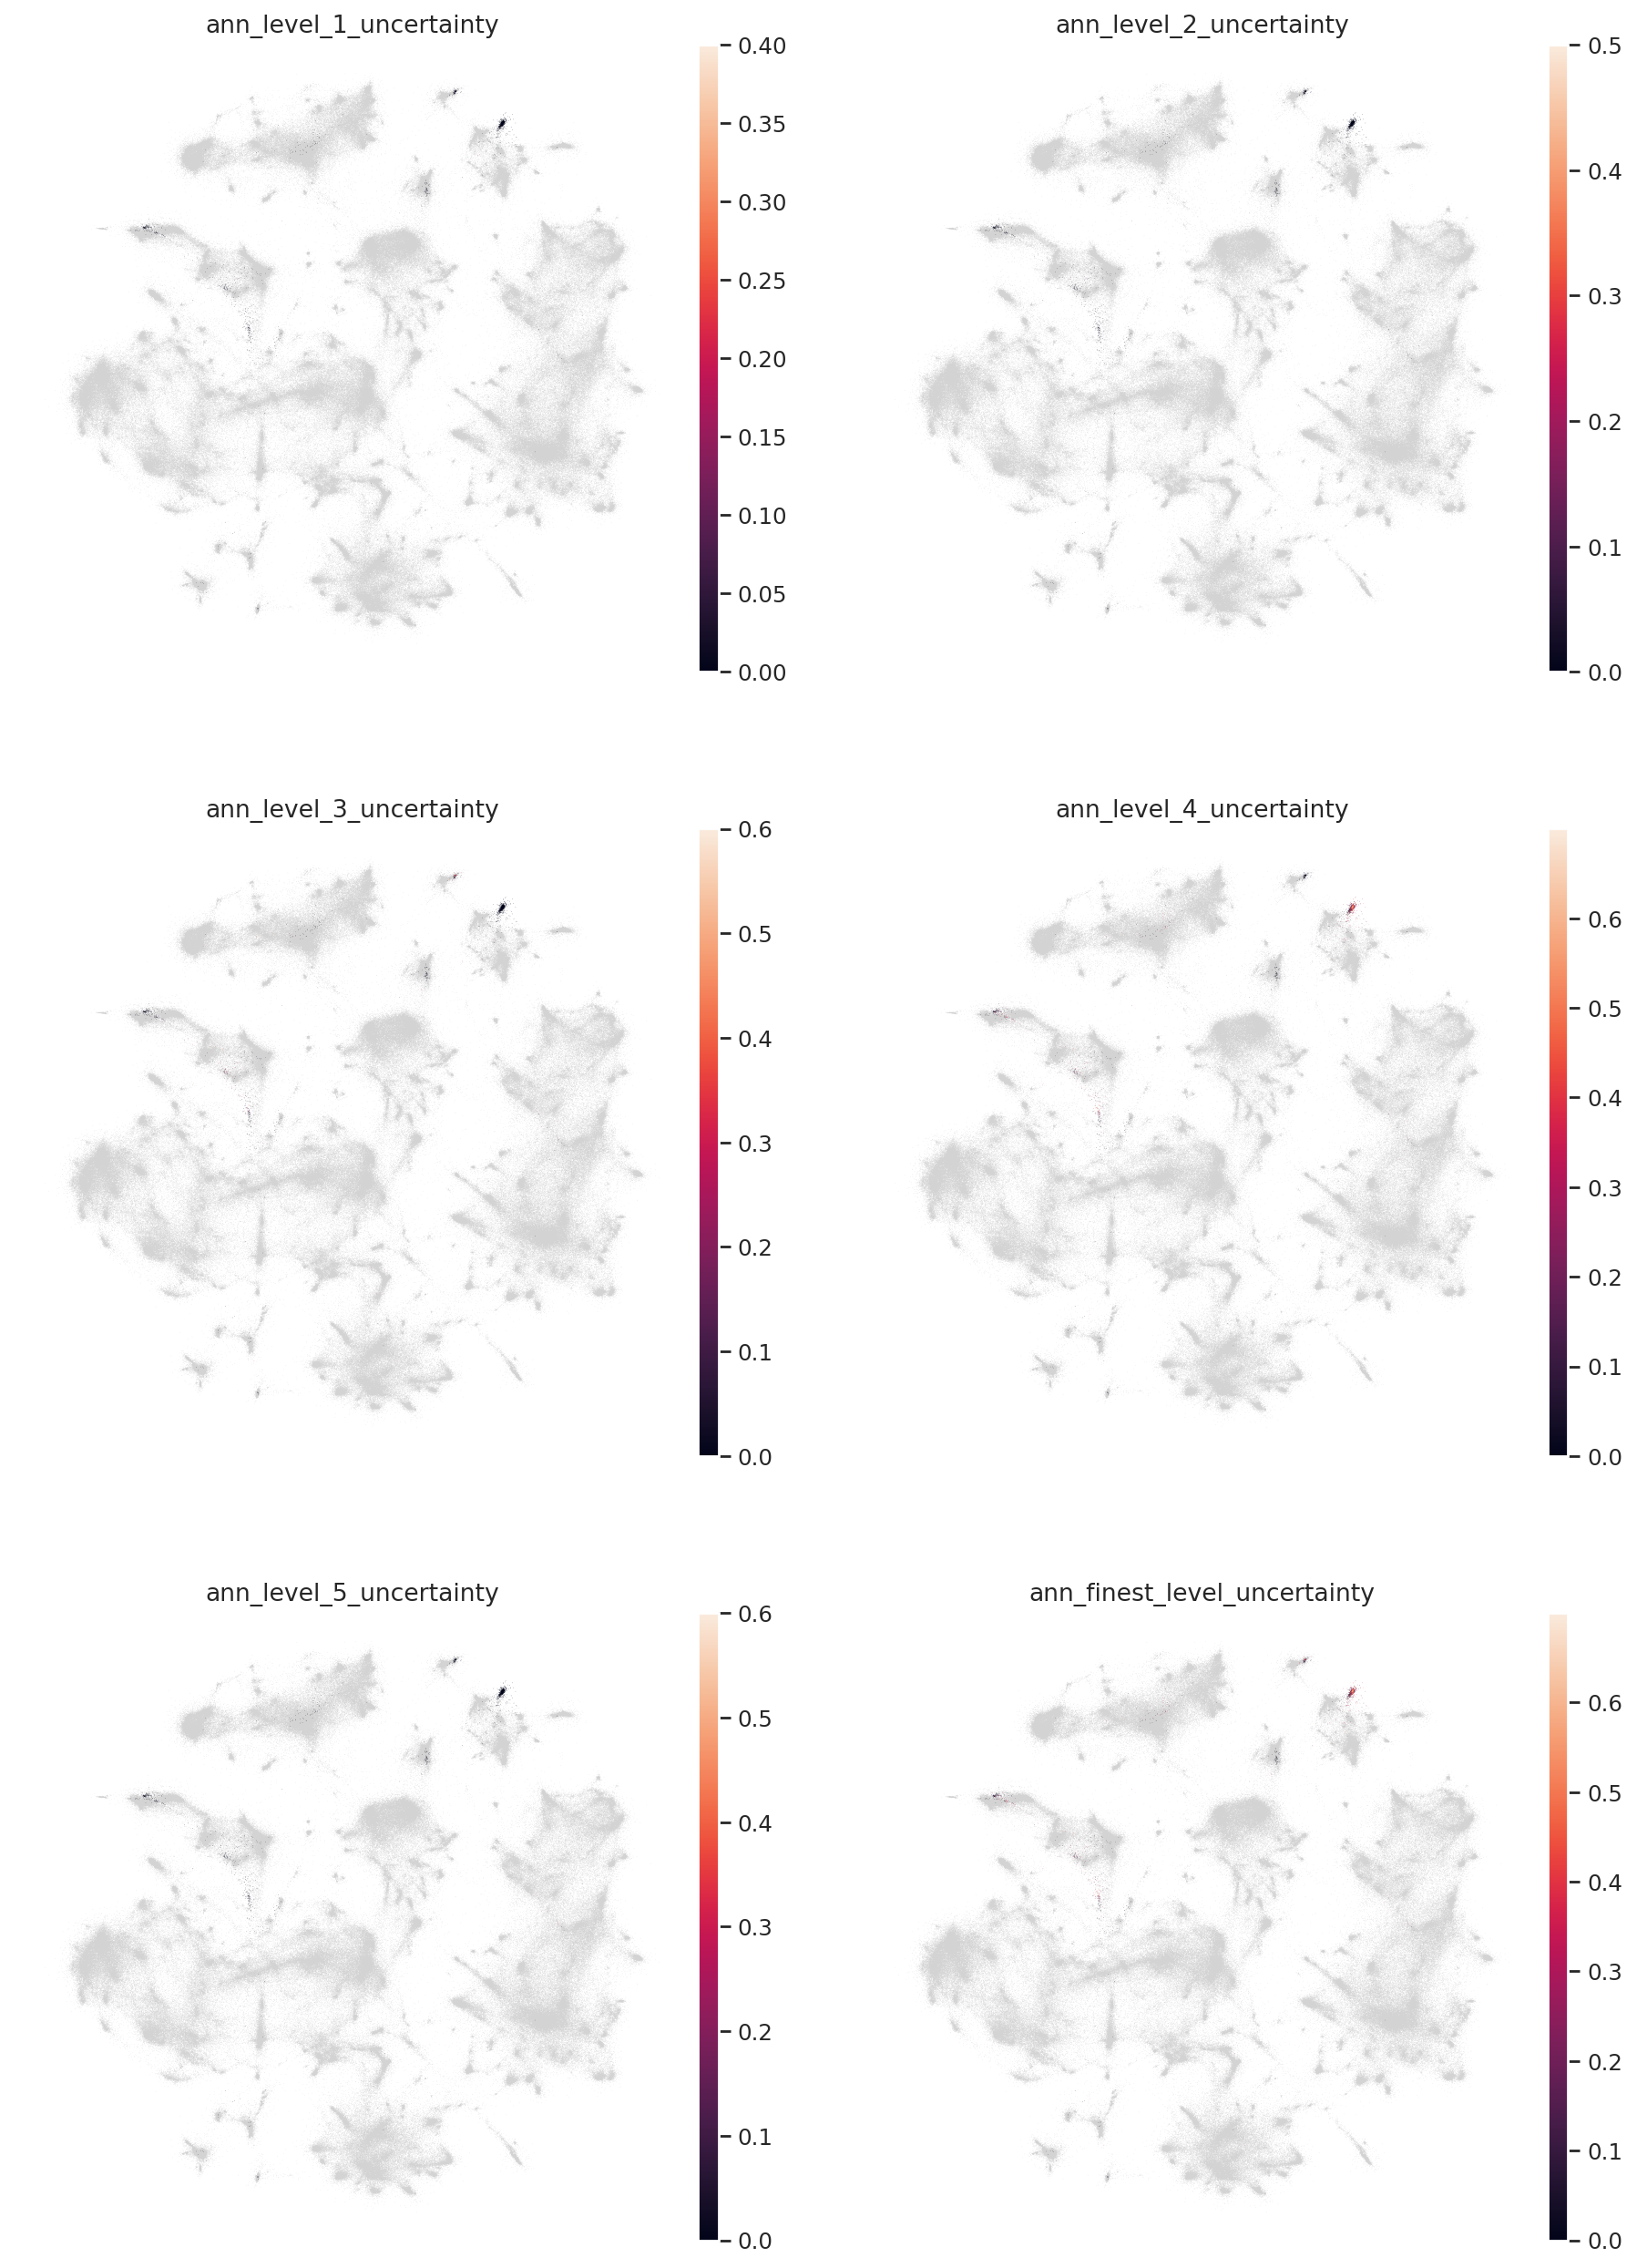

In [28]:
colors = [l + "_uncertainty" for l in label_keys]
sc.pl.embedding(
    combined_emb,
    basis=MDE_KEY,
    color=colors,
    ncols=2,
)

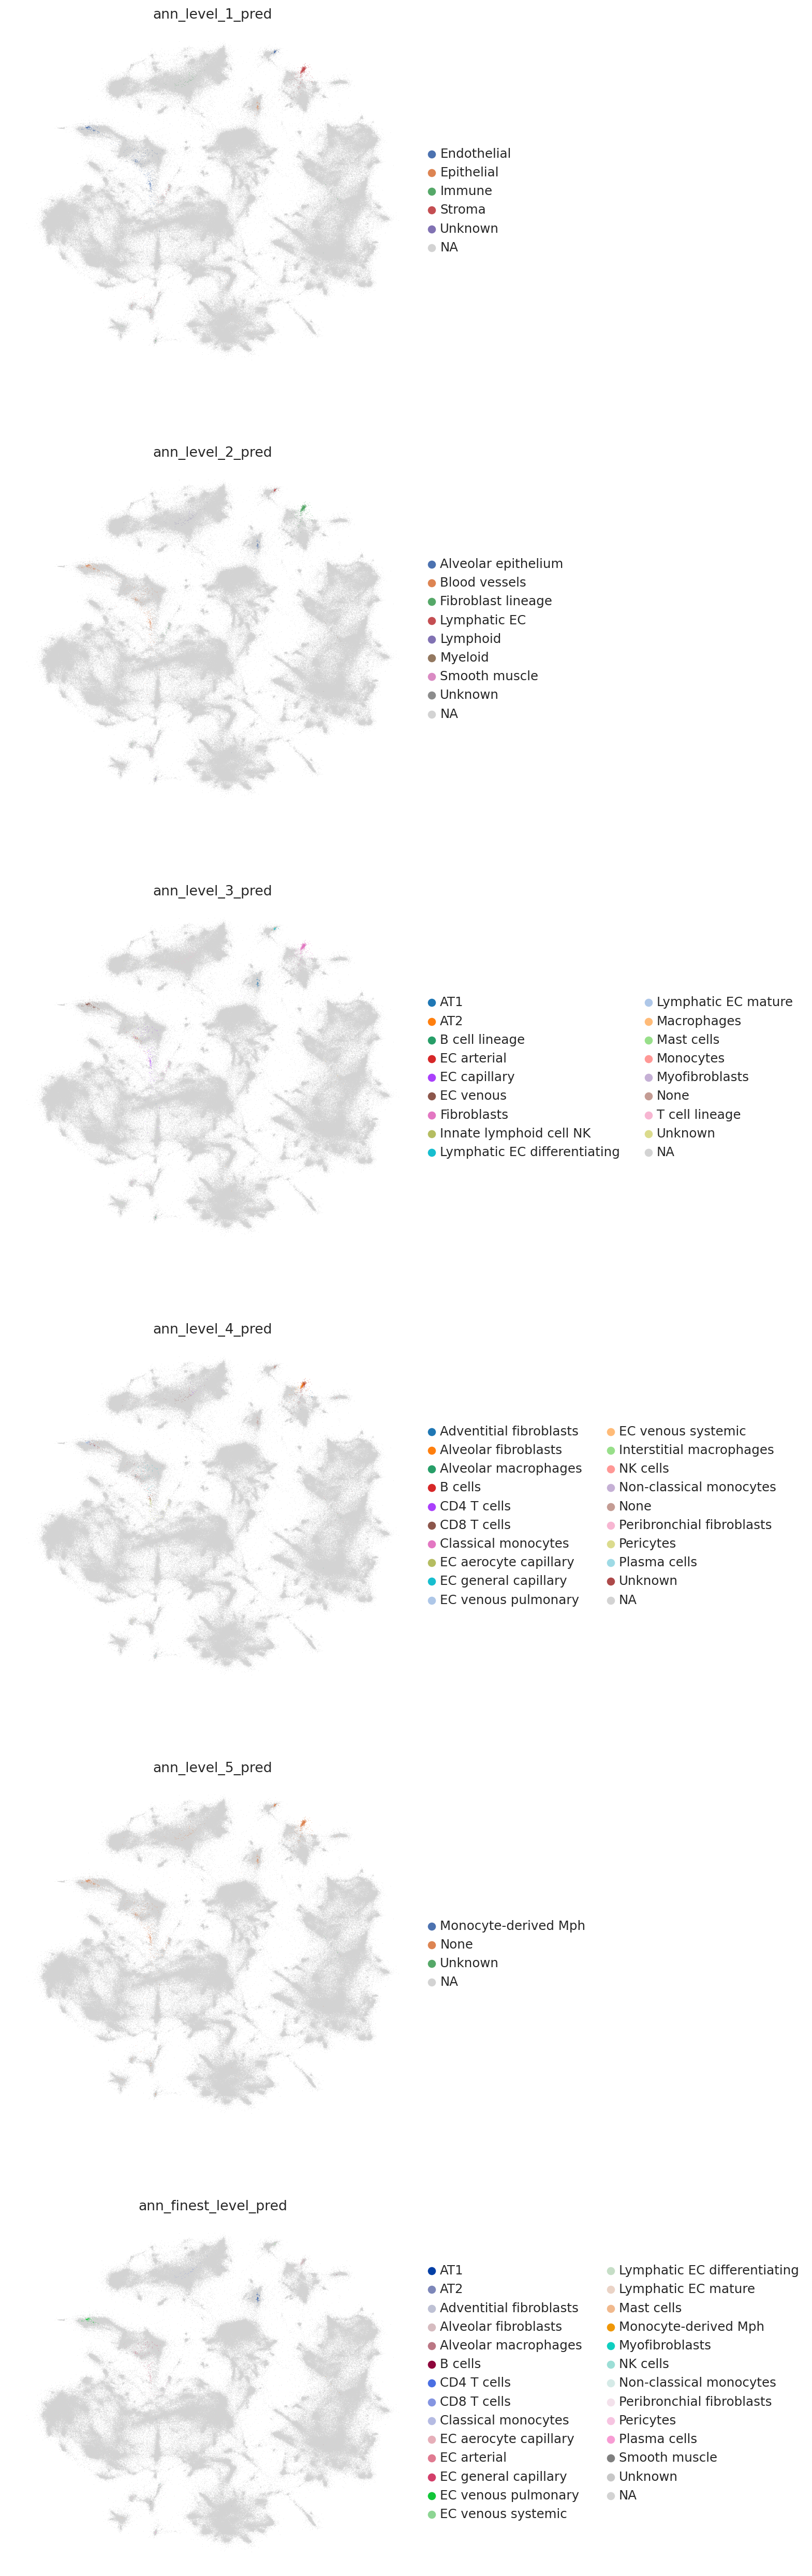

In [29]:
colors = [l + "_pred" for l in label_keys]

sc.pl.embedding(combined_emb, basis=MDE_KEY, color=colors, ncols=1, size=0.5)

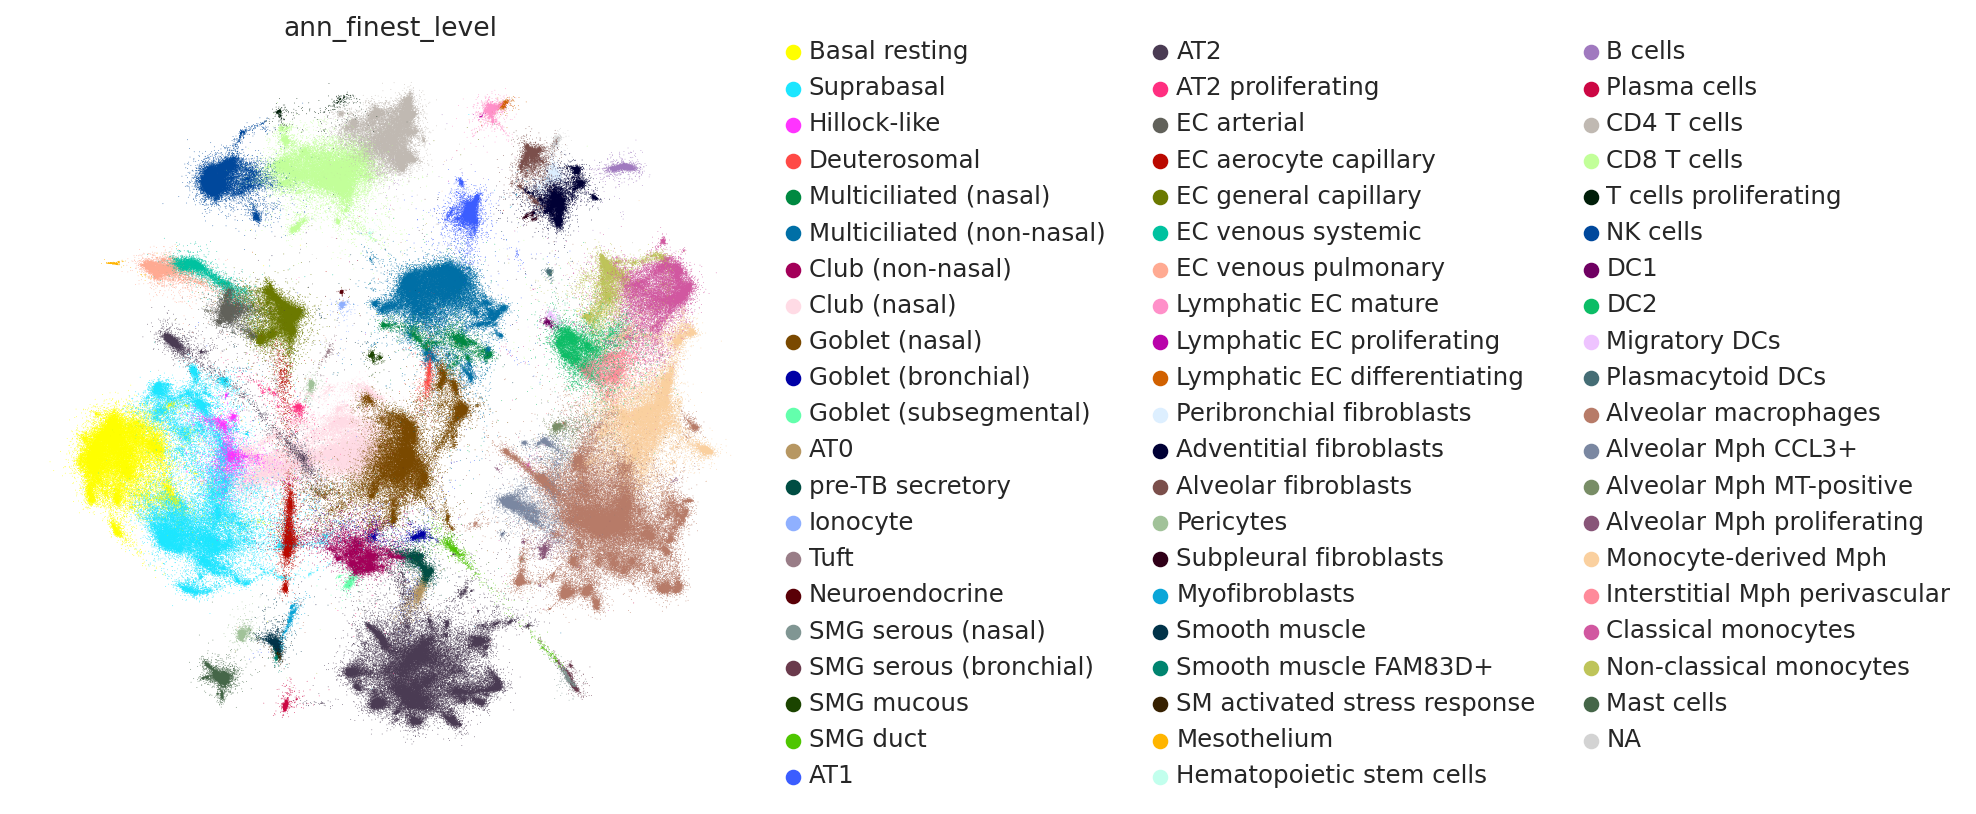

In [30]:
sc.pl.embedding(combined_emb, basis=MDE_KEY, color="ann_finest_level", ncols=1, size=0.5)